### Import dataset

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt

In [2]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

In [3]:
stock_filepath = 'result_without_news.csv' # 각자 파일 경로 설정
news_filepath = 'news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋

C:\Users\sol91\AppData\Local\Temp\ipykernel_5864\3770461931.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_fillna[column].fillna(method='ffill',inplace=True)


In [4]:
total_df.index = total_df["Date"]
total_df.drop(columns = "Date", inplace = True)
total_df['PINS'].fillna(24.99, inplace = True)
total_df

,Open,Close,High,Low,Volume,1d_ROC,5d_ROC,5MA,120MA,bol_high,...,5MM_sent_Pos,60MM_sent_Neg,60MM_sent_Neu,60MM_sent_Pos,120MM_sent_Neg,120MM_sent_Neu,120MM_sent_Pos,5MM_topics,60MM_topics,120MM_topics
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,259.28,267.66,269.75,256.58,11642148,0.000000,14.443304,260.128,325.000667,286.872017,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
2019-01-03,270.20,271.20,275.79,264.43,14954204,1.322573,6.910553,263.634,323.962333,286.339561,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
2019-01-04,281.88,297.57,297.80,278.54,19309374,9.723451,16.433854,272.034,323.104750,291.444515,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
2019-01-07,302.10,315.34,316.80,301.65,18598132,5.971704,23.141206,283.886,322.570250,300.275444,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
2019-01-08,319.98,320.27,320.59,308.01,15324452,1.563392,19.655533,294.408,322.113083,310.280492,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,494.00,486.76,496.02,485.45,2702672,-0.986554,3.114011,489.756,428.004000,500.053490,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0,7.0,7.0
2023-12-26,489.39,491.19,491.48,486.38,2032683,0.910099,1.042952,490.770,428.440250,501.759236,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0,7.0,7.0
2023-12-27,491.24,491.79,494.02,489.25,2559832,0.122152,-0.652499,490.124,428.887667,503.497049,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,7.0,7.0,7.0


### hyperparameter setting

In [6]:
SEQ_SIZE = 60
PRED_SIZE = 10
BATCH_SIZE = 5
EPOCHS = 1000

### make train test set

In [7]:
def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
        tmp_y = dataset.iloc[x_end_number:y_end_number, 1]  # Adjusted for Pandas
        x.append(tmp_x.values)  # Convert to numpy array
        y.append(tmp_y.values)  # Convert to numpy array

    return np.array(x), np.array(y)

X, y = split_xy(total_df, SEQ_SIZE, PRED_SIZE)
print(X[0,:],"\n", y[0])
print(X.shape)
print(y.shape)

[[259.28 267.66 269.75 ...   7.     7.     7.  ]
 [270.2  271.2  275.79 ...   7.     7.     7.  ]
 [281.88 297.57 297.8  ...   7.     7.     7.  ]
 ...
 [367.87 359.97 368.38 ...   7.     7.     7.  ]
 [361.   353.37 362.47 ...   7.     7.     7.  ]
 [354.48 354.61 355.94 ...   7.     7.     7.  ]] 
 [356.56 366.96 367.72 369.75 367.88 365.49 361.41 364.71 363.92 367.65]
(1188, 60, 58)
(1188, 10)


In [8]:
from sklearn.model_selection import train_test_split

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)
print("BEFORE")
print("X_train : ", X_train.shape)
print("X_test : ", X_test.shape)
print("y_train : ", y_train.shape)
print("y_test : ", y_test.shape)

# reshape datasets to 1 dimension or preprocessing
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

print("\nAFTER")
print("X_train : ", X_train.shape)
print("X_test : ", X_test.shape)
print("y_train : ", y_train.shape)
print("y_test : ", y_test.shape)

# preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# print(x_train_scaled[0,:])

BEFORE
X_train :  (950, 60, 58)
X_test :  (238, 60, 58)
y_train :  (950, 10)
y_test :  (238, 10)

AFTER
X_train :  (950, 3480)
X_test :  (238, 3480)
y_train :  (950, 10)
y_test :  (238, 10)


In [11]:
# reshape to (None,5,5)
X_train = np.reshape(X_train_scaled,
                    (X_train_scaled.shape[0], SEQ_SIZE, int(X_train_scaled.shape[1]/SEQ_SIZE)))
X_test = np.reshape(X_test_scaled,
                    (X_test_scaled.shape[0], SEQ_SIZE, int(X_train_scaled.shape[1]/SEQ_SIZE)))
print("X_train : ", X_train.shape)
print("X_test : ", X_test.shape)
# batch_size, time_step, features

X_train :  (950, 60, 58)
X_test :  (238, 60, 58)


### Modeling

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

import copy
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0, restore_best_weights = True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

class LSTMModel(nn.Module):
    def __init__(self,input_dim):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.seq = nn.Sequential(nn.Linear(64, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32),
                                nn.ReLU(),
                                nn.Linear(32, PRED_SIZE)
                                )

    def forward(self,x):
        x, _ = self.lstm(x)
#         print('output of lstm :',x.size()) # torch.Size([1, 120, 64])
        x = self.dropout(x[:,-1,:])
#         print('from lstm to linear :',x.size()) # torch.Size([1, 64])
        x = self.seq(x)
        return x

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [13]:
model = LSTMModel(int(X_train_scaled.shape[1]/SEQ_SIZE))

In [15]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20, verbose=True)

In [16]:
# to tensor
X_train_tensor = torch.tensor(X_train.astype(np.float32), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.astype(np.float32), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.astype(np.float32), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(np.float32), dtype=torch.float32)

# to DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                         batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                       batch_size = batch_size, shuffle = False)

In [18]:
epoch_counter = 0
patience = 30
best_loss = float('inf')
done = False
es = EarlyStopping(patience = patience)
tr_losses_fp, val_losses_fp = [],[]

while not done and epoch_counter < EPOCHS:
    epoch_counter+=1

    # train
    model.train()
    train_losses = []
    for x_batch,y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_fp.append(train_loss)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_fp.append(val_loss)
    scheduler.step(val_loss)

    if es(model, val_loss):
        done = True

    print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/1000, Train Loss: 220.4589, Validation Loss: 45.1619
Epoch 2/1000, Train Loss: 114.7899, Validation Loss: 33.2766
Epoch 3/1000, Train Loss: 41.7131, Validation Loss: 33.3503
Epoch 4/1000, Train Loss: 40.8757, Validation Loss: 27.2743
Epoch 5/1000, Train Loss: 38.6676, Validation Loss: 25.2383
Epoch 6/1000, Train Loss: 36.5155, Validation Loss: 23.2528
Epoch 7/1000, Train Loss: 48.2483, Validation Loss: 37.2575
Epoch 8/1000, Train Loss: 45.3703, Validation Loss: 24.9676
Epoch 9/1000, Train Loss: 37.2339, Validation Loss: 26.7452
Epoch 10/1000, Train Loss: 34.8549, Validation Loss: 21.8680
Epoch 11/1000, Train Loss: 36.2574, Validation Loss: 37.4286
Epoch 12/1000, Train Loss: 40.0620, Validation Loss: 25.8774
Epoch 13/1000, Train Loss: 34.6458, Validation Loss: 26.4409
Epoch 14/1000, Train Loss: 35.4504, Validation Loss: 23.7604
Epoch 15/1000, Train Loss: 34.8421, Validation Loss: 23.5400
Epoch 16/1000, Train Loss: 32.9302, Validation Loss: 24.2042
Epoch 17/1000, Train Loss: 34.5

Epoch 135/1000, Train Loss: 18.1698, Validation Loss: 17.7996
Epoch 136/1000, Train Loss: 17.5468, Validation Loss: 14.4406
Epoch 137/1000, Train Loss: 18.9976, Validation Loss: 14.5858
Epoch 138/1000, Train Loss: 19.0367, Validation Loss: 16.1052
Epoch 139/1000, Train Loss: 19.6223, Validation Loss: 15.1160
Epoch 140/1000, Train Loss: 17.9023, Validation Loss: 15.0791
Epoch 141/1000, Train Loss: 18.1634, Validation Loss: 17.9730
Epoch 142/1000, Train Loss: 19.5379, Validation Loss: 16.1060
Epoch 143/1000, Train Loss: 18.2747, Validation Loss: 14.3453
Epoch 144/1000, Train Loss: 18.1164, Validation Loss: 15.9810
Epoch 145/1000, Train Loss: 17.7715, Validation Loss: 14.2629
Epoch 146/1000, Train Loss: 18.0324, Validation Loss: 14.1092
Epoch 147/1000, Train Loss: 18.1628, Validation Loss: 14.5259
Epoch 148/1000, Train Loss: 18.2248, Validation Loss: 13.8146
Epoch 149/1000, Train Loss: 18.3282, Validation Loss: 16.6429
Epoch 150/1000, Train Loss: 17.9108, Validation Loss: 15.4756
Epoch 15

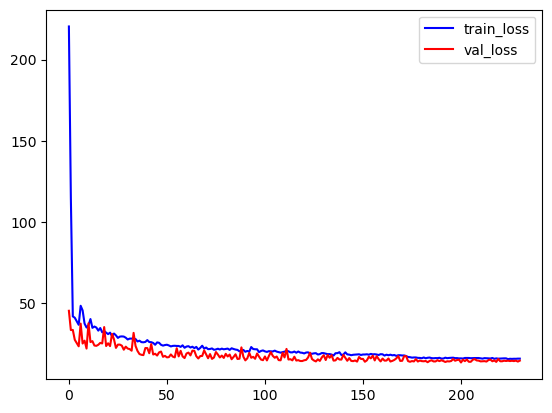

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_fp)), tr_losses_fp, color='blue', label='train_loss')
plt.plot(range(len(val_losses_fp)), val_losses_fp, color='red', label='val_loss')
plt.legend()
plt.show()

In [42]:
future = total_df.tail(SEQ_SIZE).values

future_tensor = torch.tensor(future.astype(np.float32), dtype = torch.float32)
future_tensor = future_tensor.unsqueeze(0)
future_tensor.shape

torch.Size([1, 60, 58])

In [44]:
# evaluation
model.eval()
with torch.no_grad():
    pred = model(future_tensor)
pred = pred.detach().numpy()

In [45]:
label = pd.read_csv('2024_JAN.csv')
label = np.array(label.head(PRED_SIZE)["Close"])

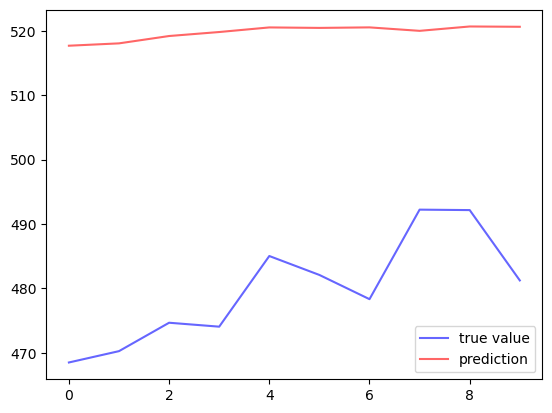

In [46]:
r = len(np.reshape(pred, (-1)))

plt.plot(list(range(r)), label, color='blue', alpha = 0.6, label='true value')
plt.plot(list(range(r)), np.reshape(pred,(-1)), color='red', alpha=0.6, label='prediction')
plt.legend()
plt.show()

In [25]:
 print(f'종가 : {label}\n예측가 : {pred}\n오차율 : {np.abs(label-pred)/label}')

종가 : [468.5  470.26 474.67 474.06 485.03 482.09 478.33 492.23 492.16 481.24]
예측가 : [[548.2986  548.74896 549.9149  550.57635 551.3167  551.2245  551.2749
  550.731   551.4442  551.34906]]
오차율 : [[0.17032782 0.16690546 0.15852048 0.16140648 0.13666518 0.14340577
  0.15249912 0.11884895 0.1204572  0.14568419]]


### Evaluation

In [31]:
np.mean(abs(label - pred)/label)

0.14747206422403486